<a href="https://colab.research.google.com/github/lelandsion/connect/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# General Libraries
import os
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Google Colab
from google.colab import drive
import gdown

# Scikit-learn (Data Processing & ML)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

# TensorFlow & Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras.models import load_model
import gc
import tensorflow.keras.backend as K

In [2]:
# Define File IDs from Google Drive
CSV_FILE_ID = "1--7jIKTCbZYbcqBhf4WWNk9XYGiskMUy"
JSON_FILE_ID = "1-Coff2iGNVDvnZAN-ku1-cOfbpqymdfM"
PICKLE_FILE_ID = "1-1Sjs3OKqw75dbJ9yi59Oa3gGArt8P_u"

# Define Local Save Paths
CSV_PATH = "/content/processed_data.csv"
JSON_PATH = "/content/processed_data.json"
PICKLE_PATH = "/content/processed_data.pkl"

# Function to download files
def download_file(file_id, output_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)

# Download Each File
download_file(CSV_FILE_ID, CSV_PATH)
download_file(JSON_FILE_ID, JSON_PATH)
download_file(PICKLE_FILE_ID, PICKLE_PATH)

print(" All files downloaded successfully!")

# Load the dataset from CSV
import pandas as pd
merged_df = pd.read_csv(CSV_PATH)

# Display first few rows to confirm
print("🔍 Sample Data:")
display(merged_df.head())

# Try loading Pickle (Fastest format)
try:
    print("Downloading Pickle dataset...")
    gdown.download(f"https://drive.google.com/uc?id={PICKLE_FILE_ID}", PICKLE_PATH, quiet=False)
    merged_df = pd.read_pickle(PICKLE_PATH)
    print("Loaded dataset from Pickle!")
except Exception as e:
    print("⚠ Pickle file not found, trying CSV...", e)

    # Fallback to CSV (If Pickle fails)
    try:
        print("Downloading CSV dataset...")
        gdown.download(f"https://drive.google.com/uc?id={CSV_FILE_ID}", CSV_PATH, quiet=False)
        merged_df = pd.read_csv(CSV_PATH)
        print("Loaded dataset from CSV!")
    except Exception as e:
        print("ERROR: Unable to load dataset!", e)
        exit()

# Load real-time JSON data (if available)
try:
    print("Downloading JSON dataset...")
    gdown.download(f"https://drive.google.com/uc?id={JSON_FILE_ID}", JSON_PATH, quiet=False)
    with open(JSON_PATH, "r") as json_file:
        json_data = json.load(json_file)
    print("Loaded JSON data for app integration!")
except Exception as e:
    print("⚠ JSON file not found, skipping real-time data.", e)

Downloading...
From (original): https://drive.google.com/uc?id=1--7jIKTCbZYbcqBhf4WWNk9XYGiskMUy
From (redirected): https://drive.google.com/uc?id=1--7jIKTCbZYbcqBhf4WWNk9XYGiskMUy&confirm=t&uuid=4925e50f-cdd7-4819-a216-39ec399fee76
To: /content/processed_data.csv
100%|██████████| 203M/203M [00:02<00:00, 94.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Coff2iGNVDvnZAN-ku1-cOfbpqymdfM
To: /content/processed_data.json
100%|██████████| 24.0/24.0 [00:00<00:00, 53.3kB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1Sjs3OKqw75dbJ9yi59Oa3gGArt8P_u
To: /content/processed_data.pkl
100%|██████████| 86.8M/86.8M [00:00<00:00, 130MB/s]


 All files downloaded successfully!
🔍 Sample Data:


,date,cerc_templogger_1,cerc_templogger_10,cerc_templogger_11,cerc_templogger_12,cerc_templogger_13,cerc_templogger_14,cerc_templogger_15,cerc_templogger_16,cerc_templogger_2,...,aru_001_cws_temp,rtu_001_sa_temp,rtu_002_sa_temp,rtu_003_sa_temp,rtu_004_sa_temp,aru_001_power_mbtuph,total_hvac,total_lighting,total_mels,hour
0,2020-01-01 00:00:00,0.045933,0.000000,0.503252,0.489130,0.604774,0.554712,0.857143,0.074557,0.423518,...,0.557672,0.681570,0.685223,0.748628,0.785548,0.02026,0.684199,0.013905,0.499896,0
1,2020-01-01 00:05:00,0.046415,0.432004,0.519356,0.491870,0.628968,0.554712,0.858286,0.075026,0.423518,...,0.557672,0.711014,0.682186,0.754116,0.789044,0.02026,0.576201,0.013517,0.392597,0
2,2020-01-01 00:10:00,0.046897,0.864009,0.535460,0.494609,0.653161,0.554712,0.859429,0.075496,0.423518,...,0.557672,0.704471,0.695344,0.750823,0.787879,0.02026,0.468203,0.013130,0.285298,0
3,2020-01-01 00:15:00,0.046897,0.863782,0.538712,0.489174,0.624968,0.554712,0.859429,0.075026,0.419827,...,0.557672,0.688113,0.691296,0.747530,0.784382,0.02026,0.360205,0.012743,0.177999,0
4,2020-01-01 00:20:00,0.046897,0.863555,0.541963,0.483739,0.596774,0.554712,0.859429,0.074557,0.416137,...,0.557672,0.690294,0.679150,0.746432,0.785548,0.02026,0.363409,0.013130,0.203477,0


Downloading...
From: https://drive.google.com/uc?id=1-1Sjs3OKqw75dbJ9yi59Oa3gGArt8P_u
To: /content/processed_data.pkl
100%|██████████| 86.8M/86.8M [00:00<00:00, 189MB/s]


Loaded dataset from Pickle!


Downloading...
From: https://drive.google.com/uc?id=1-Coff2iGNVDvnZAN-ku1-cOfbpqymdfM
To: /content/processed_data.json
100%|██████████| 24.0/24.0 [00:00<00:00, 52.9kB/s]

⚠ JSON file not found, skipping real-time data. name 'json' is not defined


In [3]:
print(merged_df.columns)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
except ValueError:
    strategy = tf.distribute.get_strategy()  # Use CPU/GPU fallback

# Load and Normalize Data
energy_cols = ["total_hvac", "total_lighting", "total_mels"]
scaler = MinMaxScaler()
merged_df[energy_cols] = scaler.fit_transform(merged_df[energy_cols])

# Define Time Window for Anomaly Detection
time_steps = 8

def create_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
    return np.array(X)

# Create sequences
X_train = create_sequences(merged_df[energy_cols].values, time_steps)

print(f" Training Data Shape: {X_train.shape}")  # (samples, time_steps, features)

# Define LSTM Autoencoder
latent_dim = 16  # Compressed representation size

with strategy.scope():
    input_layer = Input(shape=(time_steps, X_train.shape[2]))
    encoded = LSTM(latent_dim, activation="relu", return_sequences=False)(input_layer)
    decoded = RepeatVector(time_steps)(encoded)
    decoded = LSTM(X_train.shape[2], activation="relu", return_sequences=True)(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer="adam", loss="mae")

# Train the Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Save trained model
autoencoder.save("energy_anomaly_detector.keras")
print(" Model Trained and Saved!")

Index(['date', 'cerc_templogger_1', 'cerc_templogger_10', 'cerc_templogger_11',
       'cerc_templogger_12', 'cerc_templogger_13', 'cerc_templogger_14',
       'cerc_templogger_15', 'cerc_templogger_16', 'cerc_templogger_2',
       'cerc_templogger_3', 'cerc_templogger_4', 'cerc_templogger_5',
       'cerc_templogger_6', 'cerc_templogger_7', 'cerc_templogger_8',
       'cerc_templogger_9', 'zone_016_temp', 'zone_017_temp', 'zone_018_temp',
       'zone_019_temp', 'zone_021_temp', 'zone_022_temp', 'zone_023_temp',
       'zone_024_temp', 'zone_025_temp', 'zone_026_temp', 'zone_027_temp',
       'zone_028_temp', 'zone_030_temp', 'zone_032_temp', 'zone_033_temp',
       'zone_035_temp', 'zone_036_temp', 'zone_037_temp', 'zone_038_temp',
       'zone_039_temp', 'zone_040_temp', 'zone_041_temp', 'zone_042_temp',
       'zone_043_temp', 'zone_044_temp', 'zone_045_temp', 'zone_046_temp',
       'zone_047_temp', 'zone_048_temp', 'zone_049_temp', 'zone_051_temp',
       'zone_052_temp', 'zone_0

 Model Loaded!
 Test Data Shape: (112360, 8, 3)
3512/3512 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


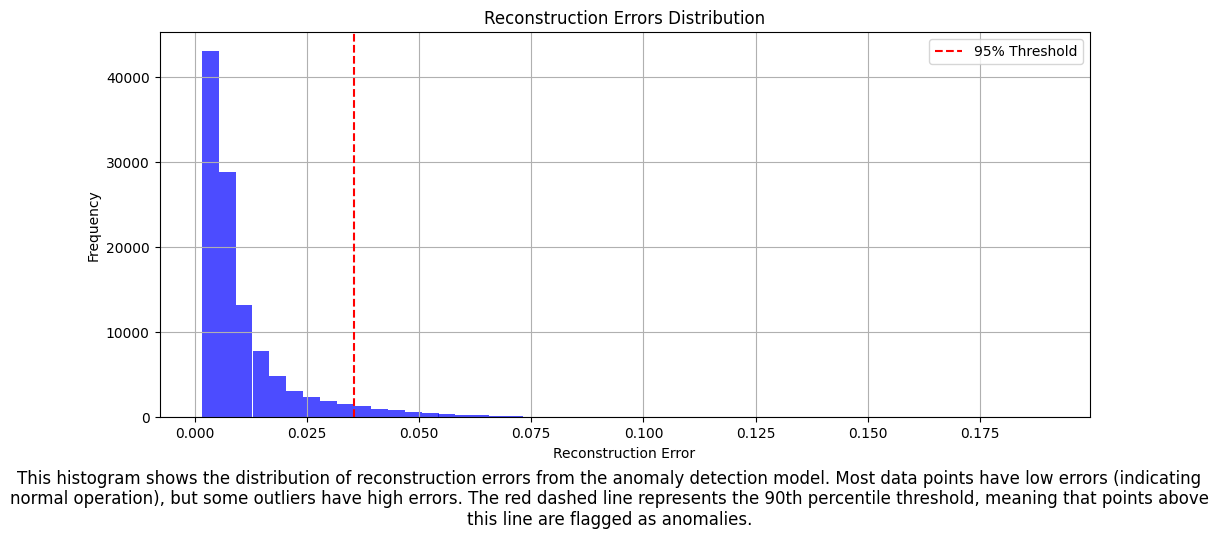

 Anomalies Detected: 2248 instances


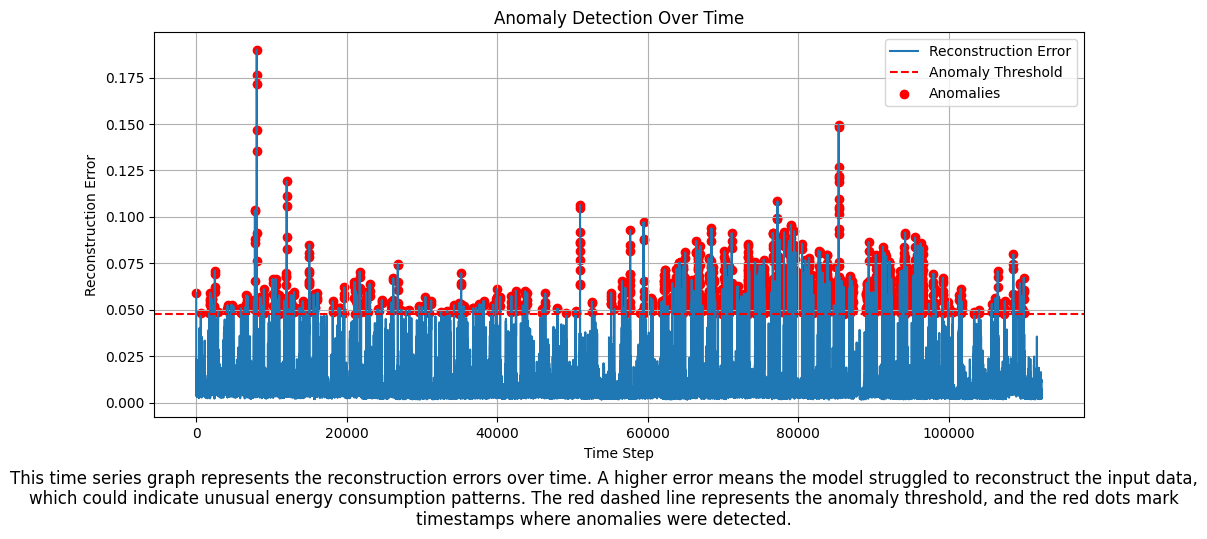

In [4]:
# Predict & Evaluate Model

# Load the trained model
model = load_model("energy_anomaly_detector.keras")
print(" Model Loaded!")

# Load & Normalize Data (if not already in session)
energy_cols = ["total_hvac", "total_lighting", "total_mels"]
scaler = MinMaxScaler()
merged_df[energy_cols] = scaler.fit_transform(merged_df[energy_cols])

# Define Time Window
time_steps = 8

def create_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
    return np.array(X)

# Prepare test data
X_test = create_sequences(merged_df[energy_cols].values, time_steps)

print(f" Test Data Shape: {X_test.shape}")

# Make Predictions
X_pred = model.predict(X_test)

# Compute Reconstruction Error (MAE)
reconstruction_errors = np.mean(np.abs(X_test - X_pred), axis=(1, 2))

# Plot Reconstruction Errors
plt.figure(figsize=(12, 5))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color="blue")
plt.axvline(np.percentile(reconstruction_errors, 95), color="red", linestyle="dashed", label="95% Threshold")
plt.title("Reconstruction Errors Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Explanation for the graph
plt.figtext(0.5, -0.1, "This histogram shows the distribution of reconstruction errors from the anomaly detection model. "
                        "Most data points have low errors (indicating normal operation), but some outliers have high errors. "
                        "The red dashed line represents the 90th percentile threshold, meaning that points above this line "
                        "are flagged as anomalies.", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Identify Anomalies
threshold = np.percentile(reconstruction_errors, 98)  # Top 5% as anomalies
anomalies = reconstruction_errors > threshold
anomalies_indices = np.where(anomalies)[0]

print(f" Anomalies Detected: {len(anomalies_indices)} instances")

# Visualize Anomalies Over Time
plt.figure(figsize=(12, 5))
plt.plot(reconstruction_errors, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="dashed", label="Anomaly Threshold")
plt.scatter(anomalies_indices, reconstruction_errors[anomalies_indices], color="red", label="Anomalies")
plt.title("Anomaly Detection Over Time")
plt.xlabel("Time Step")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
# Explanation for the graph

plt.figtext(0.5, -0.1, "This time series graph represents the reconstruction errors over time. A higher error means the model "
                        "struggled to reconstruct the input data, which could indicate unusual energy consumption patterns. "
                        "The red dashed line represents the anomaly threshold, and the red dots mark timestamps where anomalies were detected.",
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()